In [1]:
import torch 
import numpy as np
import ot 
from tqdm import tqdm
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.collections import LineCollection


torch.set_default_dtype(torch.float64)

In [2]:
class SDE(ABC):
    
    @abstractmethod
    def transition(
        self, 
        s: torch.Tensor, 
        t: torch.Tensor,
    ) -> torch.Tensor:
        pass

    @abstractmethod
    def _mean(self, t: torch.Tensor) -> torch.Tensor:
        pass 

    @abstractmethod
    def _mean_with_initial_condition(
        self, 
        t: torch.Tensor, 
        t0: torch.Tensor | None = None,
        x0: torch.Tensor | None = None,
    ) -> torch.Tensor:
        pass 

    @abstractmethod
    def _mean_with_initial_and_final_condition(
        self, 
        t: torch.Tensor, 
        t0: torch.Tensor | None = None,
        x0: torch.Tensor | None = None,
        t1: torch.Tensor | None = None,
        x1: torch.Tensor | None = None,
    ) -> torch.Tensor:
        pass 

    def mean(
        self, 
        t: torch.Tensor, 
        *,
        t0: torch.Tensor | None = None, 
        x0: torch.Tensor | None = None,
        t1: torch.Tensor | None = None,
        x1: torch.Tensor | None = None,
    ) -> torch.Tensor:
        if x0 is not None and x1 is not None:
            return self._mean_with_initial_and_final_condition(t, t0, x0, t1, x1)
        elif x0 is not None:
            return self._mean_with_initial_condition(t, t0, x0)
        else:
            return self._mean(t)

    @abstractmethod
    def _variance(
        self, 
        t: torch.Tensor, 
    ) -> torch.Tensor:
        pass 

    @abstractmethod
    def _variance_with_initial_condition(
        self, 
        t: torch.Tensor, 
        t0: torch.Tensor | None = None,
    ) -> torch.Tensor:
        pass 

    @abstractmethod
    def _variance_with_initial_and_final_condition(
        self, 
        t: torch.Tensor, 
        t0: torch.Tensor | None = None,
        t1: torch.Tensor | None = None,
    ) -> torch.Tensor:
        pass 

    def variance(
        self, 
        t: torch.Tensor, 
        t0: torch.Tensor | bool | None = None, 
        t1: torch.Tensor | bool | None = None,
    ) -> torch.Tensor:
        if t0 and t1:
            return self._variance_with_initial_and_final_condition(t, t0, t1)
        elif t0:
            return self._variance_with_initial_condition(t, t0)
        else:
            return self._variance(t)


class BridgeControl(torch.nn.Module):
    def __init__(self, sde: SDE): 
        pass

In [ ]:

class DiagonalOUBridge(torch.nn.Module):
    def __init__(self, alpha_diagonal: torch.Tensor, gamma: torch.Tensor):
        """
        parameters: 
            alpha_diagonal (torch.Tensor): Diagonal drift matrix. 
            gamma (torch.Tensor): Scalar diffusion coefficient.
        """
        super().__init__()
        self._dim = alpha_diagonal.shape[-1]
        self.alpha_diagonal = alpha_diagonal
        self.gamma_squared = gamma.square()

        # Precompute some values for conditional bridge computation.
        self.sigma11 = self.variance(torch.tensor(0.0), torch.tensor(1.0)) # [..., D]

    @property
    def dim(self) -> int:
        return self._dim

    def transition(self, s: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Returns a vector representing the transition matrix, which is itself a diagonal matrix. 

        parameters: 
            s (torch.Tensor): [...] Start times.
            t (torch.Tensor): [...] End times.

        returns: 
            torch.Tensor: [..., D] Diagonal of the transition matrix.
        """
        delta = t - s # [...]
        return torch.exp(torch.einsum("d, ... -> ...d", self.alpha_diagonal, delta))

    def mean(self, s: torch.Tensor, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Returns the mean of the SDE conditioned on being at x at time s. # TODO Maybe we should put this in the SDE class? 

        parameters: 
            s (torch.Tensor): [...] Start times.
            x (torch.Tensor): [..., D] Initial value.
            t (torch.Tensor): [...] End times.

        returns: 
            torch.Tensor: [..., D] Mean of the SDE.
        """
        return self.transition(s, t) * x # [..., D] * [..., D] -> [..., D]

    def variance(self, s: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Returns the variance of the SDE conditioned on being at x at time s. # TODO Maybe we should put this in the SDE class?

        parameters: 
            s (torch.Tensor): [...] Start times.
            t (torch.Tensor): [...] End times.

        returns: 
            torch.Tensor: [..., D] Diagonal of the variance of the SDE.
        """

        variance_alpha_zero = torch.unsqueeze(self.gamma_squared * (t - s), -1) # [..., 1]
        variance_alpha_nonzero = (
            self.gamma_squared * (self.transition(s, t).square() - 1.0) / (2 * self.alpha_diagonal)
        ) # [..., D]
        return torch.where(self.alpha_diagonal == 0, variance_alpha_zero, variance_alpha_nonzero) # [..., D]

    def covariance(self, r: torch.Tensor, s: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Returns the covariance of the SDE conditioned on being at x at time s. 

        parameters: 
            r (torch.Tensor): [..., D] Initial value.
            s (torch.Tensor): [...] Start times.
            t (torch.Tensor): [...] End times.

        returns: 
            torch.Tensor: [..., D] Covariance of the SDE.
        """
        return self.transition(s, t) * self.variance(r, s)
    
    def conditional_mean(self, t: torch.Tensor, x0: torch.Tensor, x1: torch.Tensor) -> torch.Tensor:
        """
        Returns the mean of the SDE conditioned on being at x0 at time 0 and x1 at time 1. 

        parameters: 
            t (torch.Tensor): [...] End times.
            x0 (torch.Tensor): [..., D] Initial value.
            x1 (torch.Tensor): [..., D] Target value.

        returns: 
            torch.Tensor: [..., D] Conditional mean of the SDE.
        """
        t0 = x0.new_zeros(t.shape)
        t1 = x1.new_ones(t.shape)

        mt = self.mean(t0, x0, t)
        m1 = self.mean(t0, x0, t1)
        sigma1t = self.covariance(t0, t, t1)
        sigma11 = self.sigma11

        return mt + sigma1t / sigma11 * (x1 - m1)

    def conditional_variance(self, t: torch.Tensor, x0: torch.Tensor, x1: torch.Tensor) -> torch.Tensor:
        """
        Returns the variance of the SDE conditioned on being at x0 at time 0 and x1 at time 1. 

        parameters: 
            x0 (torch.Tensor): [..., D] Initial value.
            x1 (torch.Tensor): [..., D] Target value.
            t (torch.Tensor): [...] End times.

        returns: 
            torch.Tensor: [..., D] Diagonal of the conditional variance of the SDE.
        """
        t0 = x0.new_zeros(t.shape)
        t1 = x1.new_ones(t.shape)

        sigmatt = self.variance(t0, t)
        sigma1t = self.covariance(t0, t, t1)
        sigma11 = self.sigma11

        return sigmatt - sigma1t.square() / sigma11

    def conditional_distribution(self, t: torch.Tensor, x0: torch.Tensor, x1: torch.Tensor) -> torch.distributions.Distribution:
        """
        Returns the conditional distribution of the SDE conditioned on being at x0 at time 0 and x1 at time 1. 

        parameters: 
            t (torch.Tensor): [...] End times.
            x0 (torch.Tensor): [..., D] Initial value.
            x1 (torch.Tensor): [..., D] Target value.

        returns: 
            torch.distributions.Distribution: Conditional distribution of the SDE.
        """
        assert t.shape == x0.shape[:-1], "t must have the same shape as x0 except for the last dimension"
        assert t.shape == x1.shape[:-1], "t must have the same shape as x1 except for the last dimension"

        mean = self.conditional_mean(t=t, x0=x0, x1=x1)
        stddev = self.conditional_variance(t=t, x0=x0, x1=x1).sqrt()
        normal = torch.distributions.Normal(mean, stddev) # At this point all dimensions are treated as batch dimensions. 
        return torch.distributions.Independent(normal, reinterpreted_batch_ndims=1)

    def score(self, s: torch.Tensor, x: torch.Tensor, t: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        """
        Returns the score of the bridge conditioned on being at x at time s. 

        parameters: 
            s (torch.Tensor): [...] Start times.
            x (torch.Tensor): [..., D] Initial value.
            t (torch.Tensor): [...] End times.
            y (torch.Tensor): [..., D] Target value.

        returns: 
            torch.Tensor: [..., D] Score of the bridge.
        """
        return (
            self.transition(s, t) * (y - self.mean(s, x, t)) / self.variance(s, t)
        ) # [..., D] * [..., D] / [..., D] -> [..., D]

    def control(self, s: torch.Tensor, x: torch.Tensor, x1: torch.Tensor) -> torch.Tensor:
        """
        Returns the optimal control for the bridge. 

        parameters: 
            s (torch.Tensor): [...] Start times.
            x (torch.Tensor): [..., D] Initial value.
            x1 (torch.Tensor): [..., D] Target value.

        returns: 
            torch.Tensor: [..., D] Optimal control.
        """
        # TODO: Can be simplified by cancelling out the gamma_squared. 
        t = torch.ones_like(s) # [...]
        return self.gamma_squared * self.score(s, x, t, x1) # [] * [..., D] -> [..., D]


class DiagonalizableSDE(torch.nn.Module, ABC):
    @abstractmethod
    def inverse_transform(self, x: torch.Tensor) -> torch.Tensor:
        pass


class TSHeatBM(torch.nn.Module):
    def __init__(self, L: torch.Tensor, c: torch.Tensor, sigma: torch.Tensor):
        super().__init__()
        self.L = torch.as_tensor(L, dtype=torch.float64)
        self.c = torch.as_tensor(c, dtype=torch.float64)
        self.sigma = torch.as_tensor(sigma, dtype=torch.float64)

        # diagonalize L 
        self.D, self.U = torch.linalg.eigh(self.L)

        # linear parameters 
        self.alpha_diagonal = -self.c * self.D
        self.gamma = self.sigma
        self.bridge = DiagonalOUBridge(alpha_diagonal=self.alpha_diagonal, gamma=self.gamma)

    def drift(self, s: torch.Tensor, x: torch.Tensor, x1: torch.Tensor | None = None) -> torch.Tensor:
        """
        Returns the drift of the SDE. 

        parameters: 
            s (torch.Tensor): [...] Start times.
            x (torch.Tensor): [..., D] Initial value.
            x1 (torch.Tensor): [..., D] Target value.

        returns: 
            torch.Tensor: [..., D] Drift of the SDE.
        """
        if x1 is None:
            return self.alpha_diagonal * x # [D] * [..., D] -> [..., D]
        else:
            return self.alpha_diagonal * x + self.control(s, x, x1) # [D] * [..., D] + [..., D] -> [..., D]

    def control(self, s: torch.Tensor, x: torch.Tensor, x1: torch.Tensor) -> torch.Tensor:
        return self.bridge.control(s, x, x1)

    def conditional_distribution(self, t: torch.Tensor, x0: torch.Tensor, x1: torch.Tensor) -> torch.distributions.Distribution:
        """
        Returns the conditional distribution of the SDE conditioned on being at x0 at time 0 and x1 at time 1. 

        parameters: 
            t (torch.Tensor): [...] Target times.
            x0 (torch.Tensor): [..., D] Initial value.
            x1 (torch.Tensor): [..., D] Target value.
        """
        assert t.shape == x0.shape[:-1], "t must have the same shape as x0 except for the last dimension"
        assert t.shape == x1.shape[:-1], "t must have the same shape as x1 except for the last dimension"

        return self.bridge.conditional_distribution(t=t, x0=x0, x1=x1)

    def diffusion(self, s: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        return self.gamma

    def inverse_transform(self, x: torch.Tensor) -> torch.Tensor:
        """
        Returns the inverse transform of the SDE. 

        parameters: 
            x (torch.Tensor): [..., D] Initial value.

        returns: 
            torch.Tensor: [..., D] Inverse transform of the SDE.
        """
        return torch.einsum("ij, ...j -> ...i", self.U, x) # [D, D] * [..., D] -> [..., D]


class EntropicOTSolver(torch.nn.Module):
    def __init__(self, sde: TSHeatBM, normalize_variance: bool = True):
        super().__init__()
        self.bridge = sde.bridge
        variance = self.bridge.variance(torch.tensor(0.0), torch.tensor(1.0))

        if normalize_variance:
            self._epsilon = torch.prod(variance).pow(1.0 / self.bridge.dim)
            self.normed_stddev = torch.sqrt(variance / self.epsilon) # [..., D]
        else:
            self._epsilon = 1.0
            self.normed_stddev = torch.sqrt(variance) # [..., D]

    @property
    def epsilon(self) -> torch.Tensor:
        """
        Returns the epsilon parameter for the entropic OT.

        .. math::
           \min_{\pi \in \Pi(\mu, \nu)} \mathbb{E}_{(x, y) \sim \pi}[c(x, y)] + \epsilon H(\pi)

        returns: 
            torch.Tensor: [..., D] Epsilon parameter. 
        """
        return self._epsilon

    def cost(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        """
        Returns the cost between x and y.

        parameters:
            x (torch.Tensor): [..., D] Initial value.
            y (torch.Tensor): [..., D] Target value.

        returns: 
            torch.Tensor: [...] Optimal transport cost.
        """

        s = x.new_zeros(x.shape[:-1])
        t = x.new_ones(x.shape[:-1])
        z = (y - self.bridge.mean(s, x, t)) / self.normed_stddev # ([..., D] - [..., D]) / [D] -> [..., D]
        return torch.linalg.vector_norm(z, ord=2, dim=-1) # [..., D] -> [...]

    def cost_matrix(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        """
        Returns the cost matrix between x and y.

        parameters: 
            x (torch.Tensor): [..., N, D] Initial value.
            y (torch.Tensor): [..., M, D] Target value.

        returns: 
            torch.Tensor: [..., N, M] Cost matrix.
        """
        assert x.ndim >= 2, "x must have at least 2 dimensions"
        assert y.ndim >= 2, "y must have at least 2 dimensions"

        # Expand x and y for broadcasting
        # x_expanded: [..., N, 1, D]
        # y_expanded: [..., 1, M, D]
        x_expanded = x.unsqueeze(-2)  # [..., N, 1, D]
        y_expanded = y.unsqueeze(-3)  # [..., 1, M, D]

        # Compute cost for each pair (n, m)
        # Use the same cost as in self.cost, but vectorized
        s = x.new_zeros(x.shape[:-2] + (x.shape[-2], 1))  # [..., N, 1]
        t = x.new_ones(x.shape[:-2] + (1, y.shape[-2]))   # [..., 1, M]
        # mean: [..., N, 1, D]
        mean = self.bridge.mean(s, x_expanded, t)
        # normed_variance: [D]
        z = (y_expanded - mean) / self.normed_stddev  # ([..., 1, M, D] - [..., N, 1, D]) / [D] -> [..., N, M, D]
        cost = torch.linalg.vector_norm(z, ord=2, dim=-1)  # [..., N, M]
        return cost
        
    def solve(
        self, 
        x: torch.Tensor, 
        y: torch.Tensor, 
        method: str = "sinkhorn",
        num_iter_max: int = 1000,
        stop_threshold: float = 1e-9,
        verbose: bool = False,
        log: bool = False,
        warn: bool = True,
    ) -> torch.Tensor:
        """
        Returns the optimal transport plan between x and y.

        parameters: 
            x (torch.Tensor): [N, D] Initial value.
            y (torch.Tensor): [M, D] Target value.

        returns: 
            torch.Tensor: [N, M] Optimal transport plan.
        """
        assert x.ndim == 2, "x must have 2 dimensions"
        assert y.ndim == 2, "y must have 2 dimensions"

        cost_matrix = self.cost_matrix(x, y)
        px = x.new_ones(x.shape[0]) / x.shape[0]
        py = y.new_ones(y.shape[0]) / y.shape[0]
        return ot.sinkhorn(
            a=px, 
            b=py, 
            M=cost_matrix, 
            reg=self.epsilon, 
            method=method,
            num_iter_max=num_iter_max, 
            stop_threshold=stop_threshold, 
            verbose=verbose, 
            log=log, 
            warn=warn
        )


class UniformTimesteps:
    def __init__(self, n: int):
        assert n > 1, "Number of timesteps must be greater than 1"
        self.n = n
        self.t = torch.linspace(0, 1, n + 1, dtype=torch.float64)
        self.dt = torch.full((n, ), 1.0 / n, dtype=torch.float64)


class EulerMaruyamaSolver(torch.nn.Module):
    def __init__(self, sde: TSHeatBM, n: int, timesteps: str = "uniform"):
        super().__init__()
        self.sde = sde

        if timesteps == "uniform":
            self.timesteps = UniformTimesteps(n)
        else:
            raise ValueError(f"Invalid timesteps: {timesteps}")

    def dx(self, dt: torch.Tensor, t: torch.Tensor, x: torch.Tensor, x1: torch.Tensor | None = None) -> torch.Tensor:
        """
        Returns the change in the SDE. 

        parameters: 
            dt (torch.Tensor): [] Duration of the timestep.
            t (torch.Tensor): [] Time.
            x (torch.Tensor): [..., D] Initial value.
            x1 (torch.Tensor): [..., D] Target value.

        returns: 
            torch.Tensor: [..., D] Change in the SDE.
        """
        t = t.expand(x.shape[:-1])

        drift = self.sde.drift(t, x, x1)
        diffusion = self.sde.diffusion(t, x) * torch.randn_like(x)
        return drift * dt + diffusion * torch.sqrt(dt)

    def sample_path(self, x0: torch.Tensor, x1: torch.Tensor | None = None) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Samples a path from the SDE.

        parameters: 
            x0 (torch.Tensor): [..., D] Initial value.
            x1 (torch.Tensor | None): [..., D] | [D] Target value.

        returns: 
            tuple[torch.Tensor, torch.Tensor]: [..., T, D] Path and [T] Time.
        """
        if x1 is not None:
            x1 = x1.expand_as(x0)

        ts = self.timesteps.t
        dts = self.timesteps.dt

        x = x0
        xs = [x]
        for t, dt in zip(ts[:-1], dts):
            x = x + self.dx(dt, t, x, x1)
            xs.append(x)
        return torch.stack(xs, dim=-2), ts

# Linear diffusion bridges

In [12]:
dim = 2
L = torch.eye(dim)
c = 4.0
sigma = 1.0
n = 1000

sde = TSHeatBM(L=L, c=c, sigma=sigma)
sde_solver = EulerMaruyamaSolver(sde=sde, n=n)

delta_x = torch.tensor([3.0, 0.0])
x0 = torch.tensor([-1.0, -1.0]) + delta_x
x1 = torch.tensor([1.0, 1.0]) + delta_x

# Sample 100 paths from x0 to x1
x0s = x0.expand(100, 2)
x1s = x1.expand(100, 2)
xts, ts = sde_solver.sample_path(x0s, x1s)
xts = sde.inverse_transform(xts)


xmids = sde.bridge.conditional_distribution(torch.tensor(0.8), x0, x1).sample((100,))

In [24]:
(sde.bridge.transition(s=torch.tensor(0.0), t=torch.tensor(0.8)).square() - 1.0) / (2 * sde.bridge.alpha_diagonal)

tensor([0.1248, 0.1248])

In [20]:
sde.bridge.alpha_diagonal

tensor([-4., -4.])

In [14]:
sde.bridge.variance(s=torch.tensor(0.0), t=torch.tensor(0.8))

tensor([0.1248, 0.1248])

/tmp/ipykernel_230955/3310725250.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')  # blue (low) to red (high)


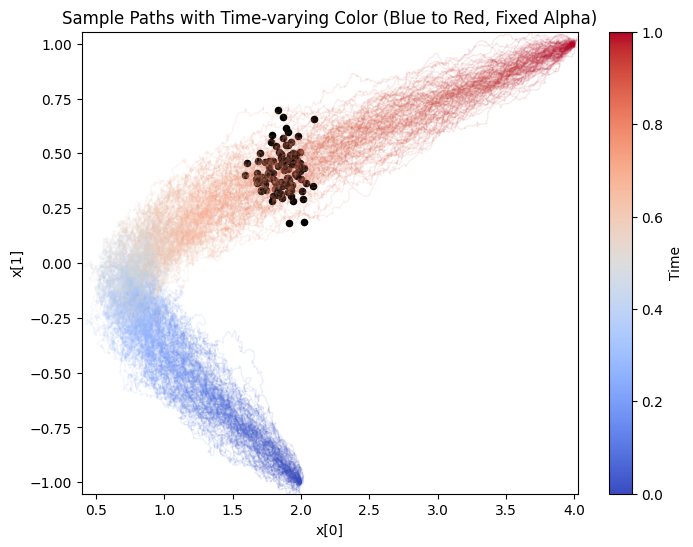

In [6]:
# Assume xts shape: [N, T, D] or [T, D] if single batch
xts_np = xts.detach().cpu().numpy()
ts_np = ts.detach().cpu().numpy()

# Ensure shape is [N, T, D]
if xts_np.ndim == 2:
    xts_np = xts_np[None, ...]  # [1, T, D]

N, T, D = xts_np.shape
assert D == 2, "D must be 2 for 2D plotting"

# Prepare segments for LineCollection: each path is (T, 2), segments are (T-1, 2, 2)
segments = []
colors = []
norm = plt.Normalize(ts_np.min(), ts_np.max())
# Use a blue-to-red colormap
cmap = cm.get_cmap('coolwarm')  # blue (low) to red (high)

# Use a single alpha value for all lines
global_alpha = 0.1

for i in range(N):
    points = xts_np[i, :, :2]
    segs = np.stack([points[:-1], points[1:]], axis=1)  # (T-1, 2, 2)
    segments.append(segs)
    # Color for each segment (time-varying colormap, fixed alpha)
    t_mid = (ts_np[:-1] + ts_np[1:]) / 2
    seg_colors = cmap(norm(t_mid))
    seg_colors[:, -1] = global_alpha  # Set the same alpha for all segments
    colors.append(seg_colors)

# Concatenate all segments and colors
all_segments = np.concatenate(segments, axis=0)
all_colors = np.concatenate(colors, axis=0)

fig, ax = plt.subplots(figsize=(8, 6))
lc = LineCollection(all_segments, colors=all_colors, linewidths=1)
ax.add_collection(lc)

# Add scatterplot of xmids, black markers
xmids_np = xmids.detach().cpu().numpy()
ax.scatter(xmids_np[:, 0], xmids_np[:, 1], color='k', marker='o', s=20, label='xmids')

# Set axis limits
all_x = xts_np[..., 0].ravel()
all_y = xts_np[..., 1].ravel()
ax.set_xlim(all_x.min(), all_x.max())
ax.set_ylim(all_y.min(), all_y.max())

ax.set_xlabel('x[0]')
ax.set_ylabel('x[1]')
ax.set_title('Sample Paths with Time-varying Color (Blue to Red, Fixed Alpha)')

# Colorbar for time
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label='Time')
plt.show()


# Optimal Transport Cost

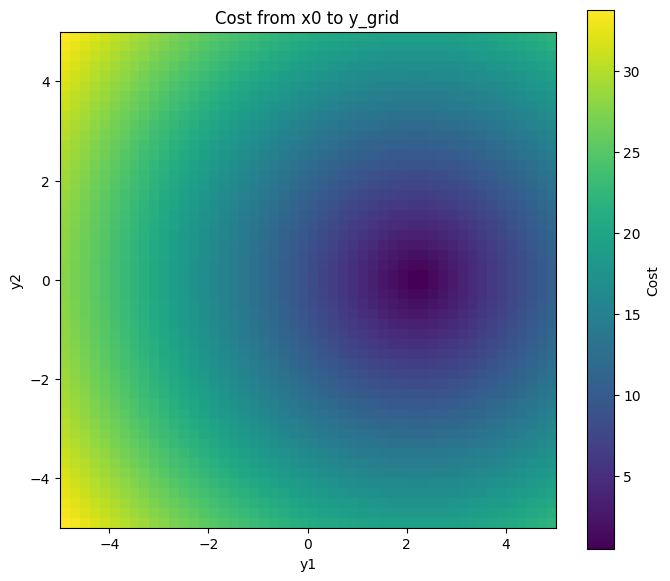

In [118]:
# Solve entropic OT problem between a centred Gaussian and a mixture of three Gaussians
dim = 2
L = torch.eye(dim)
c = 0.3
sigma = 0.3

sde = TSHeatBM(L=L, c=c, sigma=sigma)
ot_solver = EntropicOTSolver(sde=sde, normalize_variance=False)


x0 = torch.tensor([3.0, 0.0])
# Create a grid of y points and evaluate the cost from x0 to them using cost_matrix

# Define grid limits and resolution
y_min, y_max, n_grid = -5.0, 5.0, 50
y1 = torch.linspace(y_min, y_max, n_grid)
y2 = torch.linspace(y_min, y_max, n_grid)
y1g, y2g = torch.meshgrid(y1, y2, indexing='xy')
y_grid = torch.stack([y1g, y2g], dim=-1)

# Evaluate cost from x0 to each y in the grid using cost_matrix
costs = ot_solver.cost(x0.expand_as(y_grid), y_grid)


# Plot the cost as a heatmap
plt.figure(figsize=(8, 7))
plt.imshow(costs, extent=[y_min, y_max, y_min, y_max], cmap='viridis')
plt.colorbar(label='Cost')
plt.xlabel('y1')
plt.ylabel('y2')
plt.title('Cost from x0 to y_grid')
plt.show()

# Optimal transfer plan and the induced linear flow

In [119]:
delta_mu = torch.tensor([3.0, 0.0])

mu0, sigma0 = torch.zeros(2) + delta_mu, torch.eye(2) * 0.3
R0 = torch.distributions.MultivariateNormal(loc=mu0, covariance_matrix=sigma0)

r = 2.0
mu11, sigma11 = torch.tensor([0.0, 2.0]) * r + delta_mu, torch.eye(2) * 0.1
mu12, sigma12 = torch.tensor([-1.5, -1.0]) * r + delta_mu, torch.eye(2) * 0.1
mu13, sigma13 = torch.tensor([1.5, -1.0]) * r + delta_mu, torch.eye(2) * 0.1
component_distribution = torch.distributions.MultivariateNormal(
    loc=torch.stack([mu11, mu12, mu13], dim=0), 
    covariance_matrix=torch.stack([sigma11, sigma12, sigma13], dim=0)
)
mixture_distribution = torch.distributions.Categorical(probs=torch.tensor([1/3, 1/3, 1/3]))
R1 = torch.distributions.MixtureSameFamily(
    mixture_distribution=mixture_distribution, 
    component_distribution=component_distribution
)

n_samples = 100
x0 = R0.sample((n_samples,))
x1 = R1.sample((n_samples,))

ot_plan = ot_solver.solve(x0, x1)

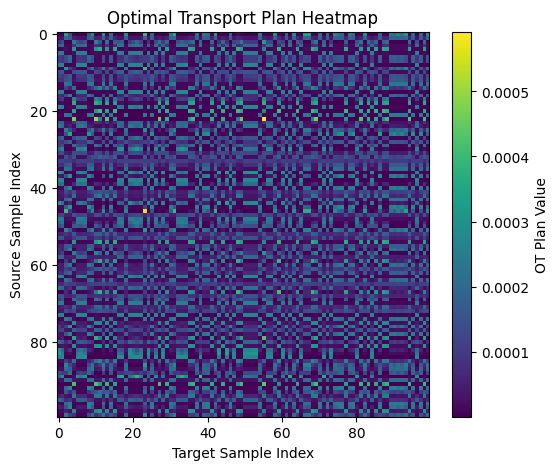

In [120]:
plt.figure(figsize=(6, 5))
plt.imshow(ot_plan, aspect='auto', cmap='viridis')
plt.colorbar(label='OT Plan Value')
plt.title('Optimal Transport Plan Heatmap')
plt.xlabel('Target Sample Index')
plt.ylabel('Source Sample Index')
plt.show()

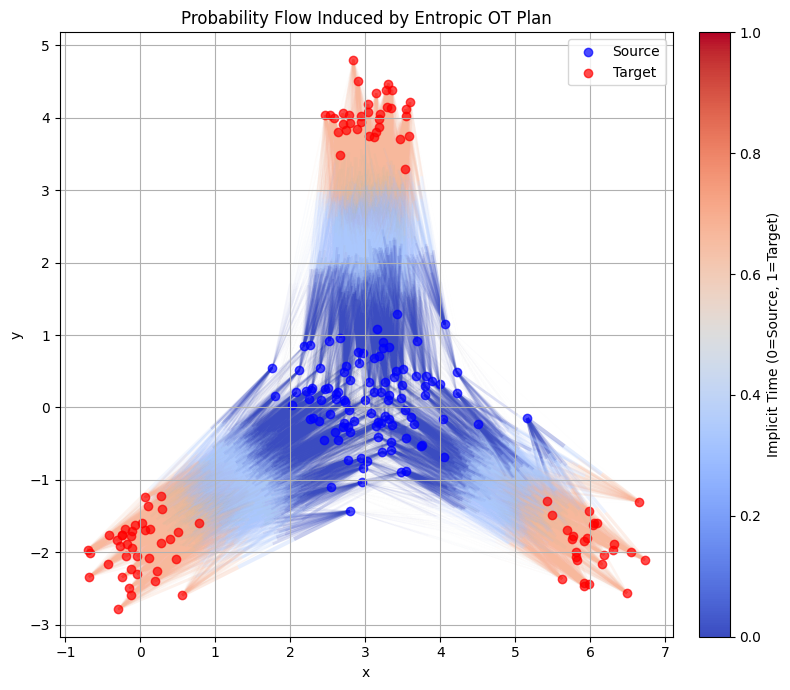

In [121]:
# Ensure x0, x1, and ot_plan are on CPU and convert to numpy arrays
x0_np = x0.cpu().numpy() if hasattr(x0, "cpu") else x0.numpy()
x1_np = x1.cpu().numpy() if hasattr(x1, "cpu") else x1.numpy()
ot_plan_np = ot_plan.cpu().numpy() if hasattr(ot_plan, "cpu") else ot_plan.numpy()

# (Assume x0_np, x1_np, ot_plan_np are already CPU NumPy arrays.)
n = x0_np.shape[0]

plt.figure(figsize=(8, 7))
ax = plt.gca()
ax.scatter(x0_np[:, 0], x0_np[:, 1],
           color='blue', label='Source', alpha=0.7)
ax.scatter(x1_np[:, 0], x1_np[:, 1],
           color='red',  label='Target', alpha=0.7)

# parameters
max_plan = ot_plan_np.max()
threshold = 0.01 * max_plan

cmap = plt.get_cmap('coolwarm')
norm = Normalize(vmin=0, vmax=1)

segments = []
colors = []
widths = []

# how many sub‐segments per arrow
n_sub = 3

for i in range(n):
    for j in range(n):
        w = ot_plan_np[i, j]
        if w <= threshold:
            continue

        start = x0_np[i]
        end = x1_np[j]
        # generate equally‐spaced points along the line
        pts = np.linspace(start, end, n_sub + 1)

        # line thickness & overall alpha from flow magnitude
        flow = w / max_plan
        lw = 0.5 + 2.5 * flow
        alpha = flow * 0.3

        # build each tiny segment
        for k in range(n_sub):
            seg_t = [pts[k], pts[k + 1]]
            t = k / n_sub  # 0 at source, 1 at target
            # pick color from cmap and inject our α
            r, g, b, _ = cmap(norm(t))
            colors.append((r, g, b, alpha))
            widths.append(lw)
            segments.append(seg_t)

# assemble the LineCollection
lc = LineCollection(segments,
                    colors=colors,
                    linewidths=widths,
                    zorder=0)
ax.add_collection(lc)

# add colorbar for “time” scale
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array(np.linspace(0, 1, 100))   # dummy array
cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Implicit Time (0=Source, 1=Target)')

ax.set(title='Probability Flow Induced by Entropic OT Plan',
       xlabel='x', ylabel='y')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


# Conditional OT Flow Matching Loss

In [122]:
def torch_divmod(n: torch.Tensor, d: int) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Equivalent to divmod for tensors. TODO If implemented nicely in pytorch, could submit a PR. 

    parameters:
        n: torch.Tensor, shape [...]
        d: int

    returns:
        tuple of tensors, shape [...]
    """
    return n // d, n % d


def joint_multinomial(distribution: torch.Tensor, num_samples: int, replacement: bool = True) -> torch.Tensor:
    """
    Sample from a joint categorical distribution.

    parameters:
        distribution: torch.Tensor, shape (N, M)
        num_samples: int, number of samples to draw
        replacement: bool, whether to sample with replacement

    returns:
        torch.Tensor, shape (num_samples, 2)
    """
    n, _ = distribution.shape
    res = torch.multinomial(distribution.flatten(), num_samples, replacement=replacement)
    res_i, res_j = torch_divmod(res, n)
    return torch.column_stack([res_i, res_j])



class UniformTimeSampler:
    def sample(self, shape: torch.Size) -> torch.Tensor:
        return torch.rand(shape)


class MatchingDataset(torch.utils.data.Dataset):
    def __init__(self, x0: torch.Tensor, x1: torch.Tensor, time_sampler: UniformTimeSampler | None = None):
        super().__init__()
        self.x0 = x0
        self.x1 = x1
        self.time_sampler = time_sampler or UniformTimeSampler()
    
    def __getitem__(self, idx: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        returns:
            t: torch.Tensor, shape [...]
            x0: torch.Tensor, shape [..., D]
            x1: torch.Tensor, shape [..., D]
        """
        x0_idx, x1_idx = torch.unbind(idx, dim=-1)
        t = self.time_sampler.sample(x0_idx.shape)
        return t, self.x0[x0_idx], self.x1[x1_idx]
    
    def __len__(self) -> int:
        raise NotImplementedError("Length of MatchingDataset is not defined.")
        

class OTBatchSampler(torch.utils.data.Sampler):
    def __init__(self, dataset: MatchingDataset, ot_solver: EntropicOTSolver, batch_size: int, num_samples: int):
        super().__init__()
        self.dataset = dataset
        self.joint_distribution = ot_solver.solve(dataset.x0, dataset.x1)
        self.batch_size = batch_size
        self.num_samples = num_samples

    def __iter__(self):
        for _ in range(len(self)):
            yield joint_multinomial(self.joint_distribution, self.batch_size)

    def __len__(self) -> int:
        return self.num_samples // self.batch_size


class MatchingDataLoader:
    def __init__(self, dataset: MatchingDataset, batch_sampler: OTBatchSampler):
        self.dataset = dataset
        self.batch_sampler = batch_sampler

    def __iter__(self):
        for batch in self.batch_sampler:
            yield self.dataset[batch]

    def __len__(self) -> int:
        return len(self.batch_sampler)


class ConditionalOTFlowMatchingLoss(torch.nn.Module):
    def __init__(self, sde: TSHeatBM):
        super().__init__()
        self.sde = sde
        self.mse = torch.nn.MSELoss()

    def forward(self, t: torch.Tensor, x0: torch.Tensor, x1: torch.Tensor, ut_preds: torch.Tensor) -> torch.Tensor:
        """
        parameters: 
            t (torch.Tensor): [...] Target times.
            x0 (torch.Tensor): [..., D] Initial value.
            x1 (torch.Tensor): [..., D] Final value.
            ut_preds (torch.Tensor): [..., D] Predicted control.

        returns: 
            torch.Tensor: Loss.
        """
        assert t.shape == x0.shape[:-1], "t must have the same shape as x0 except for the last dimension"
        assert t.shape == x1.shape[:-1], "t must have the same shape as x1 except for the last dimension"
        assert ut_preds.shape == x0.shape, "ut_preds must have the same shape as x0"
        
        xt = self.sde.conditional_distribution(t=t, x0=x0, x1=x1).sample() # [..., D]
        ut_targets = self.sde.control(t, xt, x1=x1) # [..., D]
        return self.mse(ut_targets, ut_preds) # []


In [123]:
class MLP(torch.nn.Module):
    def __init__(self, dim: int, hidden_dim: int = 10):
        super().__init__()
        self.dim = dim
        self.nn = torch.nn.Sequential(
            torch.nn.Linear(1, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, dim),
        )

    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        return self.nn(t.unsqueeze(-1))


class ResidualMLP(torch.nn.Module):
    def __init__(self, dim: int, hidden_dim: int = 64, num_layers: int = 3):
        super().__init__()
        self.dim = dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Input layer
        self.input_layer = torch.nn.Linear(1, hidden_dim)

        # Hidden layers
        self.hidden_layers = torch.nn.ModuleList()
        for _ in range(num_layers - 1):
            self.hidden_layers.append(torch.nn.Linear(hidden_dim, hidden_dim))

        # Output layer
        self.output_layer = torch.nn.Linear(hidden_dim, dim)

        self.activation = torch.nn.ReLU()

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        x = t.unsqueeze(-1)
        out = self.input_layer(x)
        for layer in self.hidden_layers:
            residual = out
            out = self.activation(out)
            out = layer(out)
            out = out + residual  # Residual connection
        out = self.activation(out)
        out = self.output_layer(out)
        return out

In [134]:
R0 = torch.distributions.MultivariateNormal(torch.ones(2), torch.eye(2))
R1 = torch.distributions.MultivariateNormal(-torch.ones(2), torch.eye(2))

x0 = R0.sample((1000,))
x1 = R1.sample((1000,))

sde = TSHeatBM(L=torch.eye(2), c=0.0, sigma=0.1)
ot_solver = EntropicOTSolver(sde=sde, normalize_variance=True)

Epochs: 100%|██████████| 100/100 [00:09<00:00, 10.96it/s, avg_loss=0.9165]


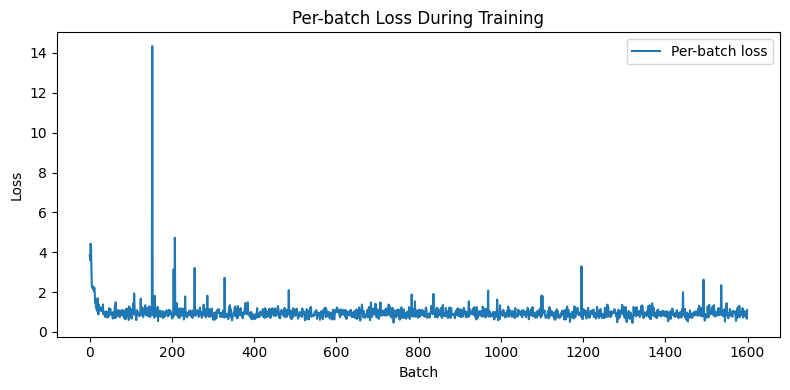

In [147]:
dataset = MatchingDataset(x0, x1)
batch_sampler = OTBatchSampler(dataset, ot_solver, batch_size=64, num_samples=1024)
data_loader = MatchingDataLoader(dataset, batch_sampler=batch_sampler)

# model = MLP(dim=2)
model = ResidualMLP(dim=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
objective = ConditionalOTFlowMatchingLoss(sde)

from tqdm import tqdm
import matplotlib.pyplot as plt

per_batch_losses = []

with tqdm(range(100), desc="Epochs") as pbar:
    for epoch in pbar:
        epoch_loss = 0.0
        num_batches = 0
        for batch_t, batch_x0, batch_x1 in data_loader:
            # batch_t = batch_t.new_full(batch_t.shape, 0.5)
            # batch_x0 = batch_x0.new_zeros(batch_x0.shape)
            # batch_x1 = batch_x1.new_ones(batch_x1.shape)

            optimizer.zero_grad()
            ut_preds = model(batch_t)
            loss = objective(t=batch_t, x0=batch_x0, x1=batch_x1, ut_preds=ut_preds)
            loss.backward()
            optimizer.step()
            batch_loss = loss.item()
            per_batch_losses.append(batch_loss)
            epoch_loss += batch_loss
            num_batches += 1
        avg_loss = epoch_loss / num_batches if num_batches > 0 else 0.0
        pbar.set_postfix({"avg_loss": f"{avg_loss:.4f}"})

# Plot per-batch loss after training
plt.figure(figsize=(8, 4))
plt.plot(per_batch_losses, label="Per-batch loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Per-batch Loss During Training")
plt.legend()
plt.tight_layout()
plt.show()

In [148]:
class ModelControl(torch.nn.Module):
    def __init__(self, model: torch.nn.Module):
        super().__init__()
        self.model = model

    def control(self, t: torch.Tensor, x0: torch.Tensor, x1: torch.Tensor) -> torch.Tensor:
        return self.model(t)

In [ ]:
sde_solver = EulerMaruyamaSolver(sde=sde, n=1000)